## Imports and common functions

In [1]:
import os
import json
import cPickle as pickle

# analysis
import pandas as pd
import numpy as np

import reverse_geocoder as rg

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load in data
Check if CSV data exists, otherwise parse .dat files into csv

In [2]:
def read_data(directory, file_name, header_names, columns_types):
    """
    Check to see if csv file exists, if not read in and parse dat file
    
    Inputs:
        directory (string): directory where data is stored
        file_name (string): file name WITHOUT extension
        header_names (list of strings): list of strings representing names for each column
        column_types (dict of numpy dtype objects): dict of column types. used to typecast columns. keys must be in header_names
        
    Output:
        (pandas dataframe): dataframe with formatted columns 
    """
    if os.path.isfile(directory + file_name + '.pickle'):
        print 'Reading pickled pandas DF: ' + directory + file_name + '.pickle'
        
        # read in pickled data frame 
        with open(directory + file_name + '.pickle', 'rb') as input_file:
            raw_data_df = pickle.load(input_file)
    else:
        print 'Reading raw txt file: ' + directory + file_name + '.txt'
        
        # read in file and format columns
        raw_data_df = pd.read_table(directory + file_name + '.txt', \
                                    names=header_names, \
                                    engine='c')
        raw_data_df = raw_data_df.astype(columns_types)
        
        # export file as pickled object
        with open(directory + file_name + '.pickle', 'wb') as output_file:
            pickle.dump(raw_data_df, output_file, pickle.HIGHEST_PROTOCOL)
        
    # return data
    return raw_data_df

In [ ]:
# read in each data frame
checkin_df = read_data('./raw_data/', 
                       'dataset_TIST2015_Checkins', 
                       ['user_id', 'venue_id', 'utc_time', 'timezone_offset'],
                       {'user_id': np.str, 'venue_id': np.str, 'utc_time': np.str, 'timezone_offset': np.int64})

cities_df = read_data('./raw_data/', 
                      'dataset_TIST2015_Cities', 
                      ['city_name', 'latitude', 'longitude', 'country_code', 'country_name', 'city_type'],
                      {'city_name': np.str, 'latitude': np.float, 'longitude': np.float, 'country_code': np.str, 'country_name': np.str, 'city_type': np.str})

venues_df = read_data('./raw_data/', 
                      'dataset_TIST2015_POIs', 
                      ['venue_id', 'latitude', 'longitude', 'venue_category', 'country_code'],
                      {'venue_id': np.str, 'latitude': np.float, 'longitude': np.float, 'venue_category': np.str, 'country_code': np.str})

Reading pickled pandas DF: ./raw_data/dataset_TIST2015_Checkins.pickle


## Data Cleaning

### Select venues in United States only

In [ ]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(venues_df['latitude'], venues_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

venues_df['city'] = cities
venues_df['state'] = states
venues_df['country'] = countries

In [ ]:
# select venues where country are in US
venues_df = venues_df[venues_df['country'] == 'US']

# select cities where country is US
cities_df = cities_df[cities_df['country_code'] == 'US']

# select checkins that are only for venues in US 
checkin_df = checkin_df[checkin_df['venue_id'].isin(venues_df['venue_id'])]

In [ ]:
checkin_by_user = checkin_df[['user_id', 'venue_id']].merge(venues_df[['venue_id', 'venue_category', 'latitude', 'longitude','city', 'state', 'country']], \
                                                            on='venue_id',
                                                            how='left')
checkin_by_user = checkin_by_user.reset_index()

In [172]:
checkin_by_user

,index,user_id,venue_id,venue_category,latitude,longitude,city,state,country
0,0,221021,4a85b1b3f964a520eefe1fe3,Coffee Shop,40.748939,-73.992280,Weehawken,New Jersey,US
1,1,66981,4b4606f2f964a520751426e3,Office,30.270753,-97.752936,Austin,Texas,US
2,2,28761,4b4bade2f964a520cfa326e3,College Arts Building,40.436712,-79.990132,Pittsburgh,Pennsylvania,US
3,3,39350,49bbd6c0f964a520f4531fe3,Arts & Crafts Store,40.719726,-74.002472,New York City,New York,US
4,4,163570,4b2277b1f964a5203f4724e3,Conference Room,41.886485,-87.623692,Chicago,Illinois,US
5,5,1702,4bbf31c9f353d13a942b7e10,Hospital,33.752959,-84.382211,Atlanta,Georgia,US
6,6,84752,4b749db3f964a520f9e72de3,Coffee Shop,47.614292,-122.341916,Seattle,Washington,US
7,7,91828,4c029902310fc9b6e2a7c461,Miscellaneous Shop,43.032290,-78.698502,Clarence Center,New York,US
8,8,44228,4a95f126f964a520952520e3,Train Station,41.875497,-87.649484,Chicago,Illinois,US
9,9,32655,4a43c0aef964a520c6a61fe3,Bridge,40.606800,-74.044170,Bensonhurst,New York,US


In [120]:
list(pd.DataFrame({'unique_location': checkin_by_user.groupby('venue_category')['index'].nunique()}).reset_index().sort_values('unique_location', ascending=False)['venue_category'])

['Home (private)',
 'Office',
 'Coffee Shop',
 'Bar',
 'Airport',
 'Grocery Store',
 'American Restaurant',
 'Residential Building (Apartment / Condo)',
 'Gym',
 'Hotel',
 'Building',
 'Department Store',
 'Mexican Restaurant',
 'Gym / Fitness Center',
 'Mall',
 'Road',
 'Park',
 'Fast Food Restaurant',
 'Gas Station / Garage',
 'Pizza Place',
 'Neighborhood',
 'Train Station',
 'Burger Joint',
 'Sandwich Place',
 'Subway',
 'Church',
 'Italian Restaurant',
 'Pub',
 'Drugstore / Pharmacy',
 'Bank',
 'Sports Bar',
 'Nightclub',
 'Caf\x1a\x1a',
 'Electronics Store',
 'Gay Bar',
 'Other Great Outdoors',
 'City',
 'Hospital',
 'Clothing Store',
 'General Entertainment',
 'Automotive Shop',
 'Diner',
 'Government Building',
 'Multiplex',
 'Salon / Barbershop',
 'Coworking Space',
 'Miscellaneous Shop',
 'Baseball Stadium',
 'Convenience Store',
 'Bakery',
 'Music Venue',
 'Breakfast Spot',
 'Lounge',
 'Chinese Restaurant',
 'Seafood Restaurant',
 'Bus Line',
 'Sushi Restaurant',
 'Movie The

## Exploratory Analysis

### Visualize number of venues by State and City

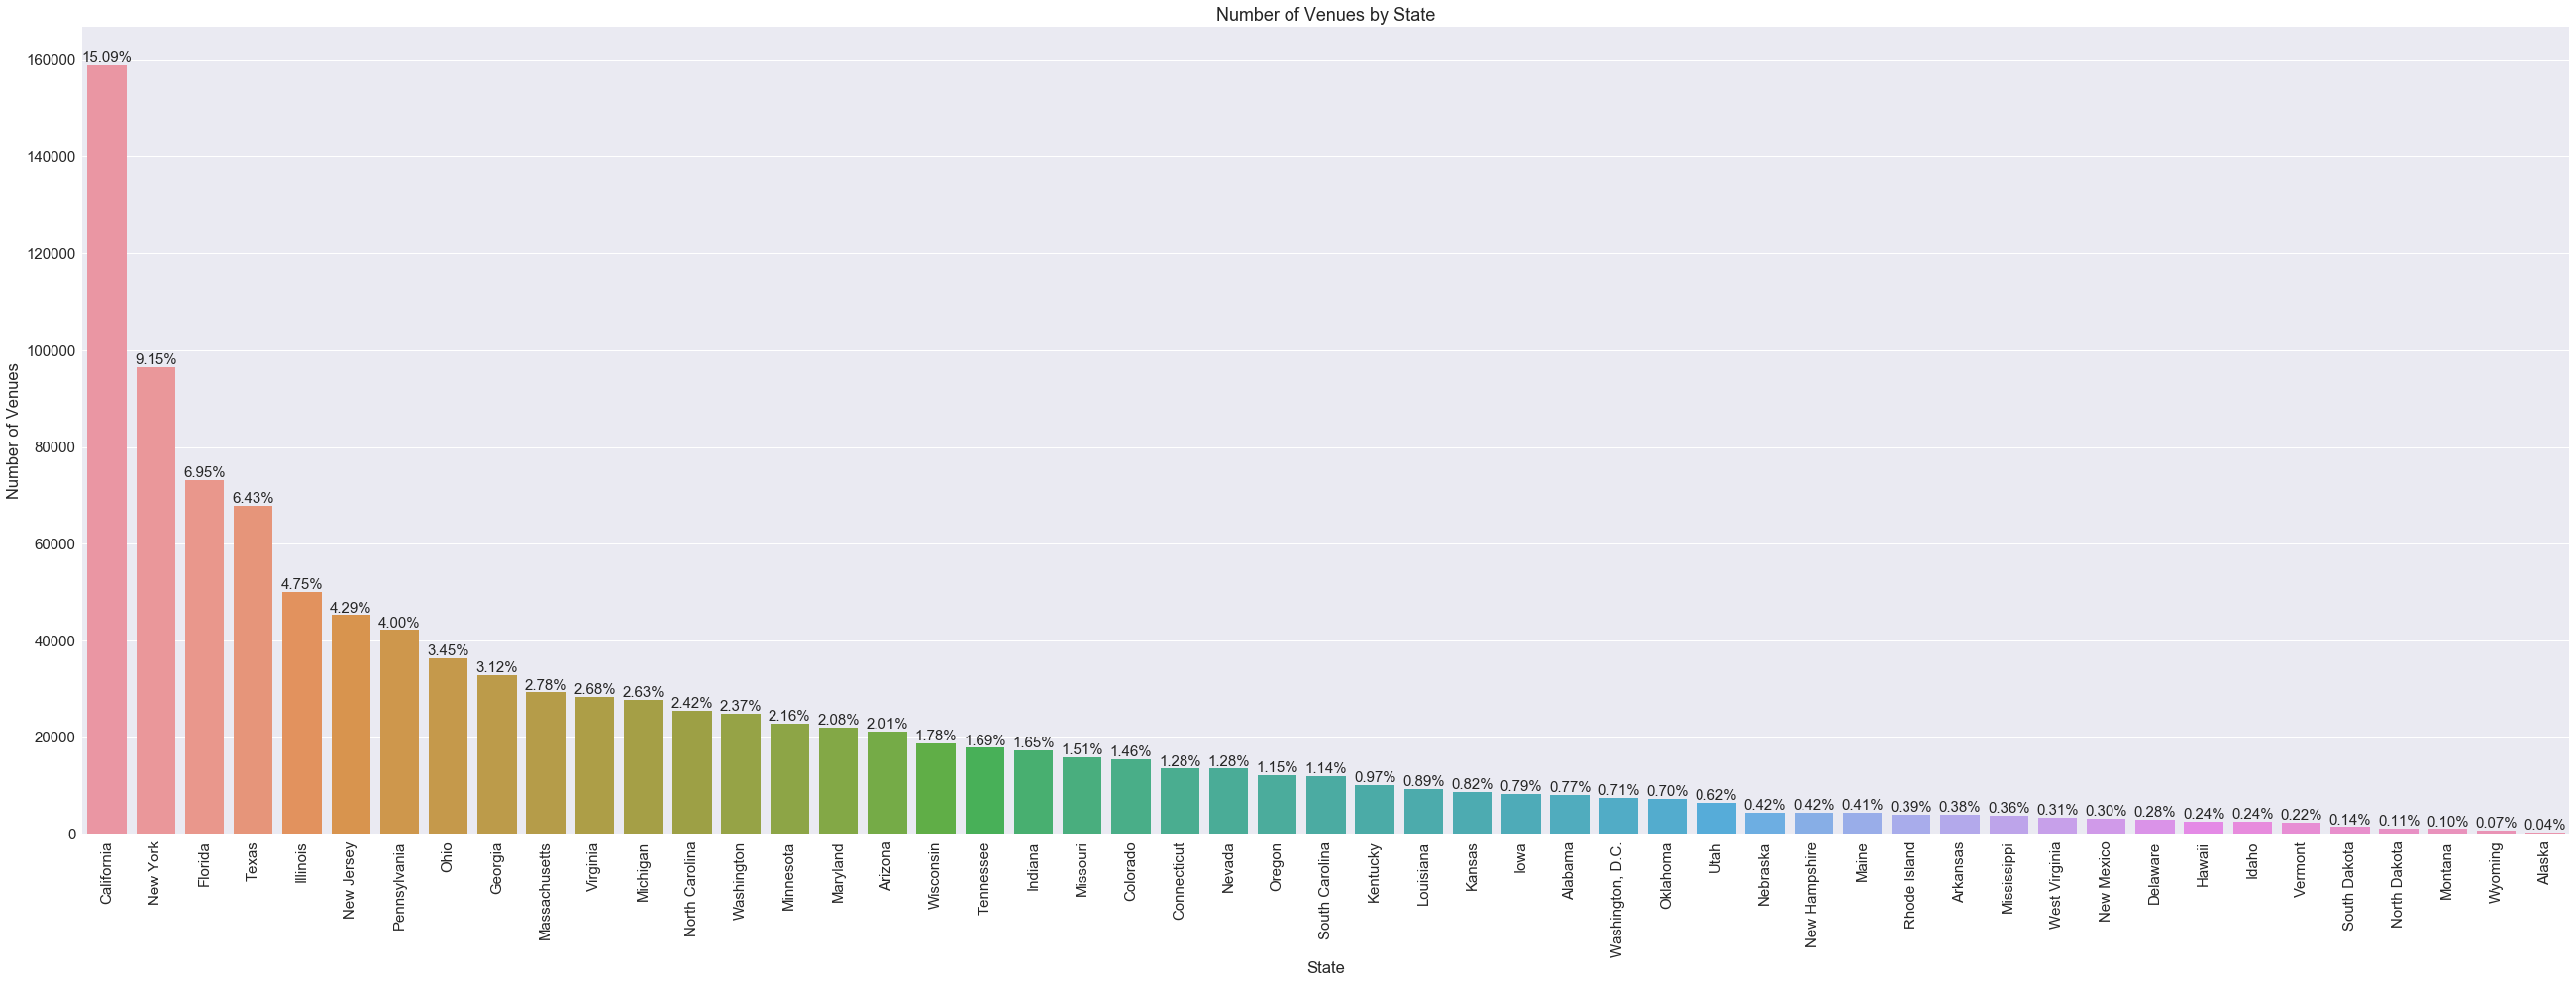

In [53]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
state_ordering = venues_df['state'].value_counts().index.tolist()
state_count = sns.countplot(venues_df['state'], order=state_ordering)
state_count.set_xlabel('State')
state_count.set_ylabel('Number of Venues')
state_count.set_title('Number of Venues by State')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

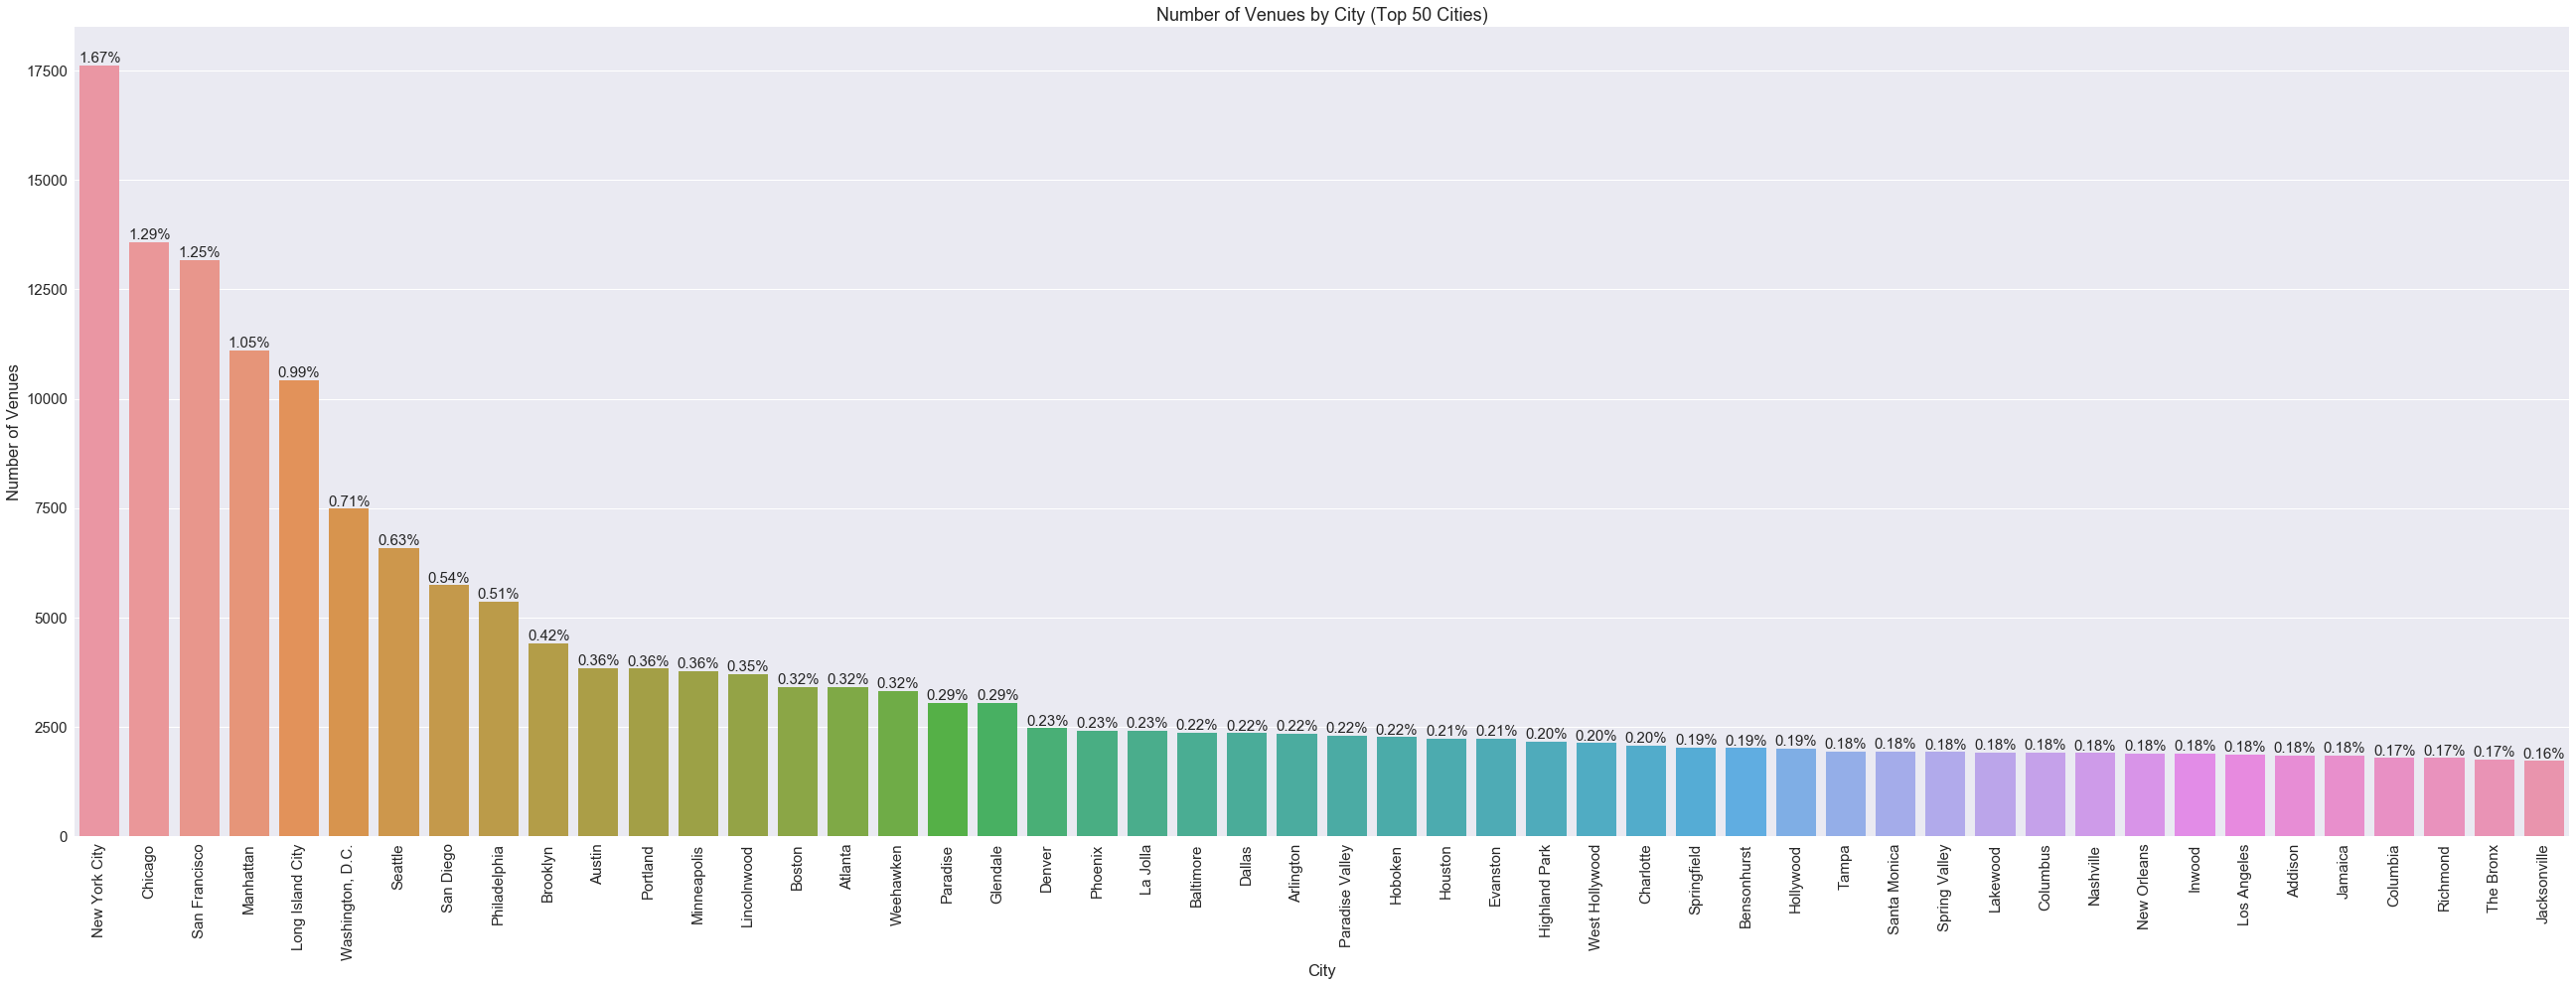

In [54]:
sns.despine();
sns.set(font_scale=1.5);

fig, ax = plt.subplots(figsize=(45, 15));
city_ordering = venues_df['city'].value_counts().index.tolist()[0:50]
city_count = sns.countplot(venues_df[venues_df['city'].isin(city_ordering)]['city'], order=city_ordering)
city_count.set_xlabel('City')
city_count.set_ylabel('Number of Venues')
city_count.set_title('Number of Venues by City (Top 50 Cities)')
plt.xticks(rotation=90)

total = len(venues_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height,
            '{:1.2f}%'.format(100 * height / total),
            ha='center',
            va='bottom',
            fontsize=15) 

### How are people connected across cities and states? 

In [188]:
# assign cities and countries
current_reverse_geocode = rg.search(zip(user_df['latitude'], user_df['longitude']))
cities = [x['name'] for x in current_reverse_geocode]
states = [x['admin1'] for x in current_reverse_geocode]
countries = [x['cc'] for x in current_reverse_geocode]

user_df['city'] = cities
user_df['state'] = states
user_df['country'] = countries

# select only users who are in the United States
user_df = user_df[user_df['country'] == 'US']

In [134]:
venues_df[venues_df['city'].isin(['San Jose'])]

,venue_id,latitude,longitude,venue_category,country_code,city,state,country
829,3fd66200f964a52088f11ee3,37.328912,-121.893589,Italian Restaurant,US,San Jose,California,US
2676,40c3b000f964a520e2001fe3,37.332171,-121.884588,Mexican Restaurant,US,San Jose,California,US
2677,40c3b000f964a520e3001fe3,37.332664,-121.884369,Mexican Restaurant,US,San Jose,California,US
2742,40d77680f964a52060011fe3,37.339858,-121.893488,German Restaurant,US,San Jose,California,US
5049,4287e280f964a52030231fe3,37.329233,-121.900973,Bar,US,San Jose,California,US
5100,428a8580f964a52096231fe3,37.334982,-121.888488,Cocktail Bar,US,San Jose,California,US
5101,428a8580f964a52098231fe3,37.326693,-121.891927,Museum,US,San Jose,California,US
5136,428fcb80f964a520ec231fe3,37.336125,-121.890222,Nightclub,US,San Jose,California,US
5188,42966300f964a5205b241fe3,37.333818,-121.893201,Nightclub,US,San Jose,California,US
5239,429f9d80f964a520c7241fe3,37.335881,-121.892879,American Restaurant,US,San Jose,California,US


In [121]:
current_reverse_geocode

[{'admin1': 'New York',
  'admin2': '',
  'cc': 'US',
  'lat': '40.71427',
  'lon': '-74.00597',
  'name': 'New York City'},
 {'admin1': 'New York',
  'admin2': 'New York County',
  'cc': 'US',
  'lat': '40.78343',
  'lon': '-73.96625',
  'name': 'Manhattan'},
 {'admin1': 'New York',
  'admin2': '',
  'cc': 'US',
  'lat': '40.71427',
  'lon': '-74.00597',
  'name': 'New York City'},
 {'admin1': 'Massachusetts',
  'admin2': 'Suffolk County',
  'cc': 'US',
  'lat': '42.35843',
  'lon': '-71.05977',
  'name': 'Boston'},
 {'admin1': 'Pennsylvania',
  'admin2': 'Philadelphia County',
  'cc': 'US',
  'lat': '39.95233',
  'lon': '-75.16379',
  'name': 'Philadelphia'},
 {'admin1': 'New York',
  'admin2': 'Kings County',
  'cc': 'US',
  'lat': '40.60177',
  'lon': '-73.99403',
  'name': 'Bensonhurst'},
 {'admin1': 'New York',
  'admin2': '',
  'cc': 'US',
  'lat': '40.71427',
  'lon': '-74.00597',
  'name': 'New York City'},
 {'admin1': 'New York',
  'admin2': 'Queens County',
  'cc': 'US',
  '

In [57]:
# select only graph edges where both nodes ids appear in user_df 
socialgraph_df = socialgraph_df[(socialgraph_df['first_user_id'].isin(user_df['id'])) &
                                  (socialgraph_df['second_user_id'].isin(user_df['id']))]

In [66]:
# create social graph by location
location_socialgraph_df = pd.concat([socialgraph_df.merge(user_df[['id', 'city', 'state']], left_on='first_user_id', right_on='id', how='left')[['first_user_id', 'second_user_id', 'city', 'state']],
                                     socialgraph_df.merge(user_df[['id', 'city', 'state']], left_on='second_user_id', right_on='id', how='left')[['city', 'state']]], axis=1)
location_socialgraph_df.columns = ['first_user_id', 'second_user_id',
                                   'first_user_city', 'first_user_state',
                                   'second_user_city', 'second_user_state']

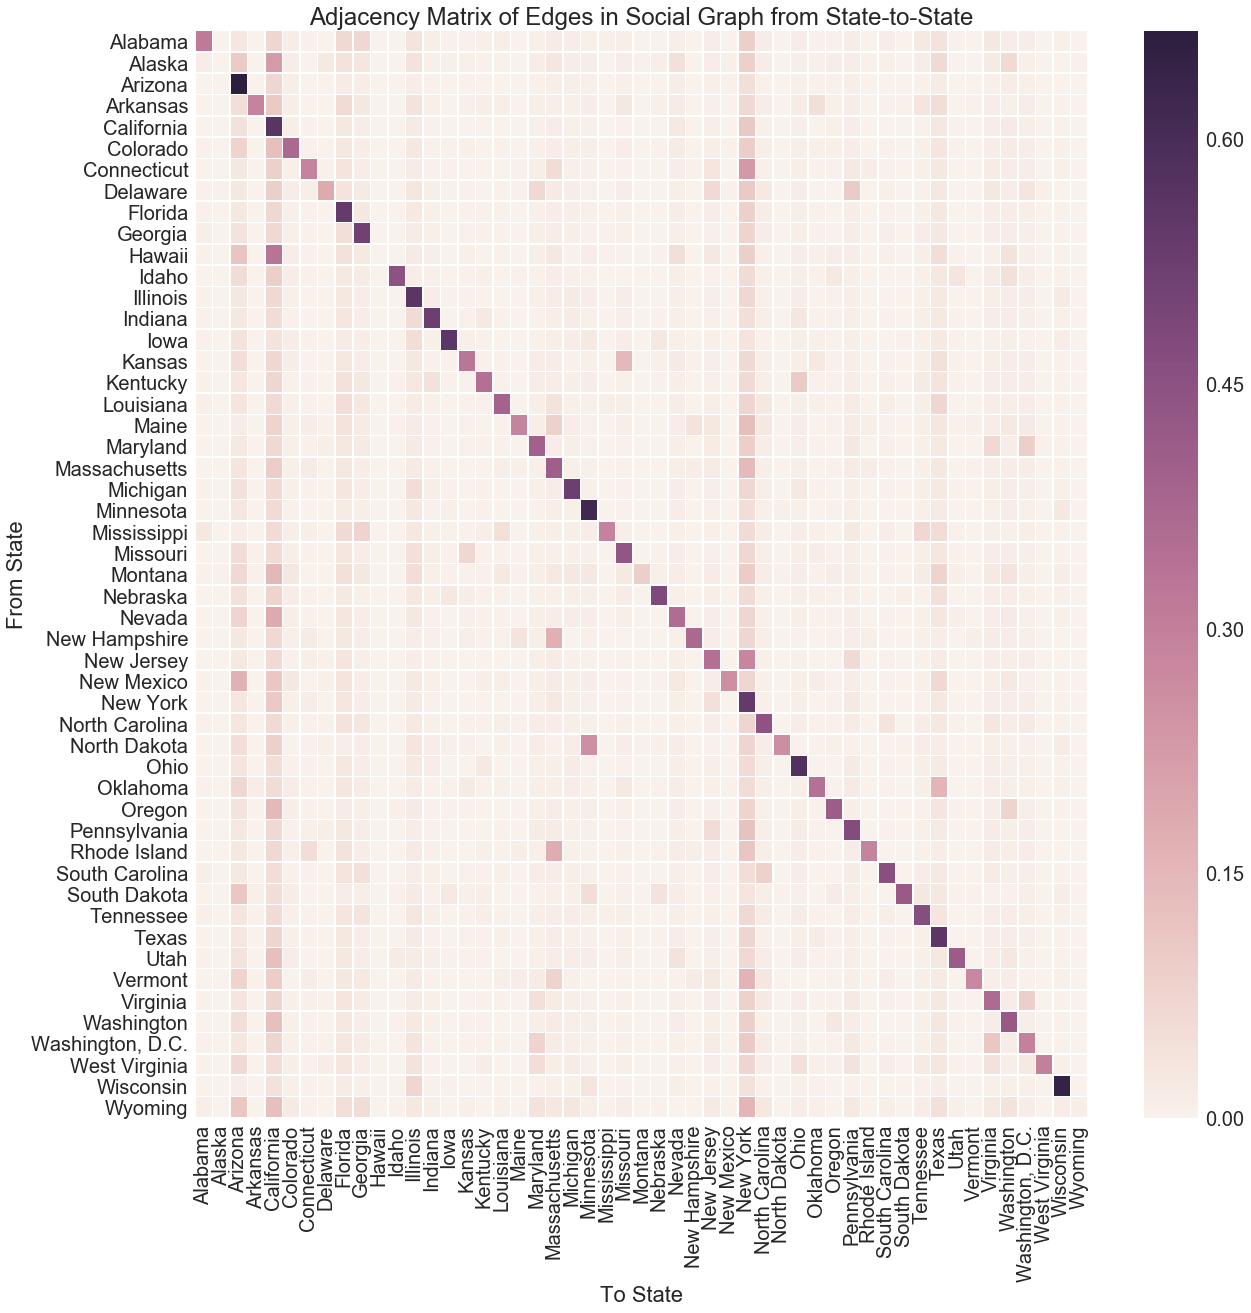

In [140]:
# create and state-level adj matrix and visualize
state_social_adj = pd.crosstab(location_socialgraph_df.first_user_state, location_socialgraph_df.second_user_state,
                               normalize='index')

fig, ax = plt.subplots(figsize=(20, 20));
sns.despine();
sns.set(font_scale=2);
state_graph_heatmap = sns.heatmap(state_social_adj, linewidths=.5)
state_graph_heatmap.set_xlabel('To State')
state_graph_heatmap.set_ylabel('From State')
state_graph_heatmap.set_title('Adjacency Matrix of Edges in Social Graph from State-to-State')

### How do user's check-in to locations across states and cities?

In [40]:
# compute summary stats of checkins by user
checkin_by_user_agg = pd.DataFrame({'count': checkin_by_user.groupby(['user_id'])['index'].count()}).reset_index()
checkin_by_user_agg['count'].describe()

count    50751.000000
mean        70.151701
std        120.358155
min          1.000000
25%          6.000000
50%         33.000000
75%         91.000000
max       4104.000000
Name: count, dtype: float64

In [42]:
# get unique contributions in each city for each user
checkin_byuser_city = pd.DataFrame({'unique_location': checkin_by_user.groupby(['user_id'])['city'].unique()}).reset_index()
checkin_byuser_city['unique_location_count'] = checkin_byuser_city.unique_location.apply(len)

# get unique contributions in each state for each user
checkin_byuser_state = pd.DataFrame({'unique_location': checkin_by_user.groupby(['user_id'])['state'].unique()}).reset_index()
checkin_byuser_state['unique_location_count'] = checkin_byuser_state.unique_location.apply(len)

In [43]:
# compute summary stats of checkins in unique cities
checkin_byuser_city['unique_location_count'].describe()

count    50751.000000
mean         9.036551
std          7.720529
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max        126.000000
Name: unique_location_count, dtype: float64

In [44]:
# compute summary stats of checkins in unique states
checkin_byuser_state['unique_location_count'].describe()

count    50751.000000
mean         2.812437
std          2.467018
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         27.000000
Name: unique_location_count, dtype: float64

In [47]:
# count number of checkins by city
checkin_bycity_user = pd.DataFrame({'unique_checkins': checkin_by_user.groupby(['city'])['index'].unique()}).reset_index()
checkin_bycity_user['unique_checkins_count'] = checkin_bycity_user.unique_checkins.apply(len)

In [48]:
checkin_bycity_user['unique_checkins_count'].describe()

count      1868.000000
mean       1905.925589
std        7131.186601
min           1.000000
25%         150.000000
50%         478.500000
75%        1334.000000
max      154947.000000
Name: unique_checkins_count, dtype: float64

## Do users have common checkins across cities?

In [2]:
# get unique contributions in each city for each user
checkin_byuser_city = pd.DataFrame({'unique_location': checkin_by_user.groupby(['user_id'])['city'].unique()}).reset_index()
checkin_byuser_city['unique_location_count'] = checkin_byuser_city.unique_location.apply(len)

NameError: name 'checkin_by_user' is not defined

In [3]:
# select only users with more than 1 location checkin
checkin_byuser_city = checkin_byuser_city[checkin_byuser_city['unique_location_count'] > 1]

NameError: name 'checkin_byuser_city' is not defined

In [103]:
# find top 50 cities and create indicies for them
top_cities = checkin_bycity_user.sort_values('unique_checkins_count', ascending=False).iloc[0:50]['city']
city_indicies = {}

count = 0
for i in top_cities:
    city_indicies[i] = count
    count +=1

In [112]:
# create adj matrix to hold everything
adj_matrix = [[0 for x in top_cities] for y in top_cities]

# iterate through checkins by user by city
for index, row in checkin_byuser_city.iterrows():
    for i in row['unique_location']:
        if i in city_indicies:
            i_index = city_indicies[i]

            for j in row['unique_location']:
                if j in city_indicies:
                    j_index = city_indicies[j]
                    adj_matrix[i_index][j_index] += 1

In [113]:
zip(top_cities, [np.mean(x) for x in adj_matrix])

[('New York City', 1349.3599999999999),
 ('Chicago', 620.67999999999995),
 ('Manhattan', 1370.72),
 ('Washington, D.C.', 712.94000000000005),
 ('San Francisco', 550.10000000000002),
 ('Long Island City', 1085.72),
 ('Philadelphia', 371.92000000000002),
 ('Austin', 365.94),
 ('San Diego', 343.18000000000001),
 ('Weehawken', 1112.8800000000001),
 ('Seattle', 243.02000000000001),
 ('Atlanta', 337.07999999999998),
 ('Minneapolis', 184.58000000000001),
 ('Boston', 373.56),
 ('Milwaukee', 103.78),
 ('Honolulu', 78.5),
 ('Brooklyn', 463.24000000000001),
 ('Inwood', 819.34000000000003),
 ('Baltimore', 260.12),
 ('Charlotte', 143.5),
 ('Lincolnwood', 225.09999999999999),
 ('Houston', 172.62),
 ('Los Angeles', 378.68000000000001),
 ('West Hollywood', 370.98000000000002),
 ('Dallas', 209.19999999999999),
 ('Hollywood', 381.04000000000002),
 ('Glendale', 208.72),
 ('Portland', 179.41999999999999),
 ('Jacksonville', 72.780000000000001),
 ('Phoenix', 153.94),
 ('New Orleans', 232.36000000000001),
 (

In [173]:
with open('./processed_data/jennie_full.pickle', 'wb') as output_file:
    pickle.dump(checkin_by_user, output_file, pickle.HIGHEST_PROTOCOL)

In [ ]:
fiona_collection = fiona.open('./raw_data/ZillowNeighborhoods-CA.shx')
tiny_checkin_df = checkin_by_user[checkin_by_user['city'] == 'San Francisco'][0:10]

i = 0
def getNeighborhood(x):
    lat = x[4]
    lon = x[5]
    point = shapely.geometry.Point(lon, lat) # longitude, latitude

    for shapefile_record in fiona_collection:

         # Use Shapely to create the polygon
        shape = shapely.geometry.asShape(shapefile_record['geometry'])

        if point.within(shape):
            try: 
                i+=1
                print i
                return shapefile_record['properties']['Name']
            except:
                return None
        
tiny_checkin_df['neighborhood'] = tiny_checkin_df.apply(getNeighborhood, axis=1)

# Look at neighborhoods between cities (currently SF, Chi, NY)

In [2]:
# read in processed data from Jennie 
chi = pd.read_csv('./processed_data/chi.csv', index_col=0)
nyc = pd.read_csv('./processed_data/nyc.csv', index_col=0)
sf = pd.read_csv('./processed_data/sf.csv', index_col=0)

neighborhood_df = pd.concat([chi, nyc, sf], axis=0)
neighborhood_df = neighborhood_df[neighborhood_df['neighborhood'].notnull()]

In [3]:
neighborhoods_byuser = pd.DataFrame({'count' : neighborhood_df.groupby(['user_id', 'venue_category', 'city', 'neighborhood']).size()}).reset_index()
neighborhoods_byuser['unique_neighborhood'] = neighborhoods_byuser['neighborhood'] + '|' + neighborhoods_byuser['city']

In [4]:
neighborhood_list_byuser = pd.DataFrame({'neighborhood_list' : neighborhoods_byuser.groupby(['user_id', 'venue_category'])['unique_neighborhood'].unique(),
                                         'neighborhood_count' : neighborhoods_byuser.groupby(['user_id', 'venue_category'])['unique_neighborhood'].nunique(),
                                         'city_list' : neighborhoods_byuser.groupby(['user_id', 'venue_category'])['city'].unique(),
                                         'city_count' : neighborhoods_byuser.groupby(['user_id', 'venue_category'])['city'].nunique()}).reset_index()
neighborhood_list_byuser = neighborhood_list_byuser.sort_values('city_count', ascending=False)
neighborhood_list_byuser = neighborhood_list_byuser[neighborhood_list_byuser['city_count'] > 1]

In [5]:
neighborhood_list_byuser

,user_id,venue_category,city_count,city_list,neighborhood_count,neighborhood_list
1447,23334,American Restaurant,3,"[Chicago, New York City, San Francisco]",5,"[Near North|Chicago, River North|Chicago, Batt..."
3531,125155,New American Restaurant,3,"[Chicago, New York City, San Francisco]",3,"[River North|Chicago, Flatiron District|New Yo..."
2632,63650,Dive Bar,3,"[Chicago, New York City, San Francisco]",3,"[Lake View|Chicago, Lower East Side|New York C..."
1011,12238,Nightclub,3,"[Chicago, New York City, San Francisco]",5,"[Gold Coast|Chicago, Near North|Chicago, Noble..."
2000,39131,Italian Restaurant,3,"[Chicago, New York City, San Francisco]",4,"[Near North|Chicago, Greenwich Village|New Yor..."
562,5575,Hotel,3,"[Chicago, New York City, San Francisco]",4,"[Streeterville|Chicago, The Loop|Chicago, SoHo..."
3781,162323,Office,3,"[Chicago, New York City, San Francisco]",3,"[The Loop|Chicago, SoHo|New York City, South B..."
1513,23355,Tech Startup,3,"[Chicago, New York City, San Francisco]",6,"[Goose Island|Chicago, Flatiron District|New Y..."
2517,60396,Bar,3,"[Chicago, New York City, San Francisco]",3,"[River North|Chicago, West Village|New York Ci..."
853,9721,Nightclub,3,"[Chicago, New York City, San Francisco]",3,"[River North|Chicago, West Village|New York Ci..."


In [18]:
# create matrix of neighborhood similarity
# increase similarity if user has been to same venue in multiple neighborhoods

# create adj matrix to hold everything
unique_neighborhoods = np.unique(np.concatenate(list(neighborhood_list_byuser['neighborhood_list'])))
adj_matrix = [[0 for x in unique_neighborhoods] for y in unique_neighborhoods]

# create index lookup table
neighborhood_indicies = {}

count = 0
for i in unique_neighborhoods:
    neighborhood_indicies[i] = count
    count +=1

# iterate through checkins by user by city
for index, row in neighborhood_list_byuser.iterrows():
    for i in row['neighborhood_list']:
        for j in row['neighborhood_list']:
            if i == j:
                continue
            else:
                adj_matrix[neighborhood_indicies[i]][neighborhood_indicies[j]] += 1

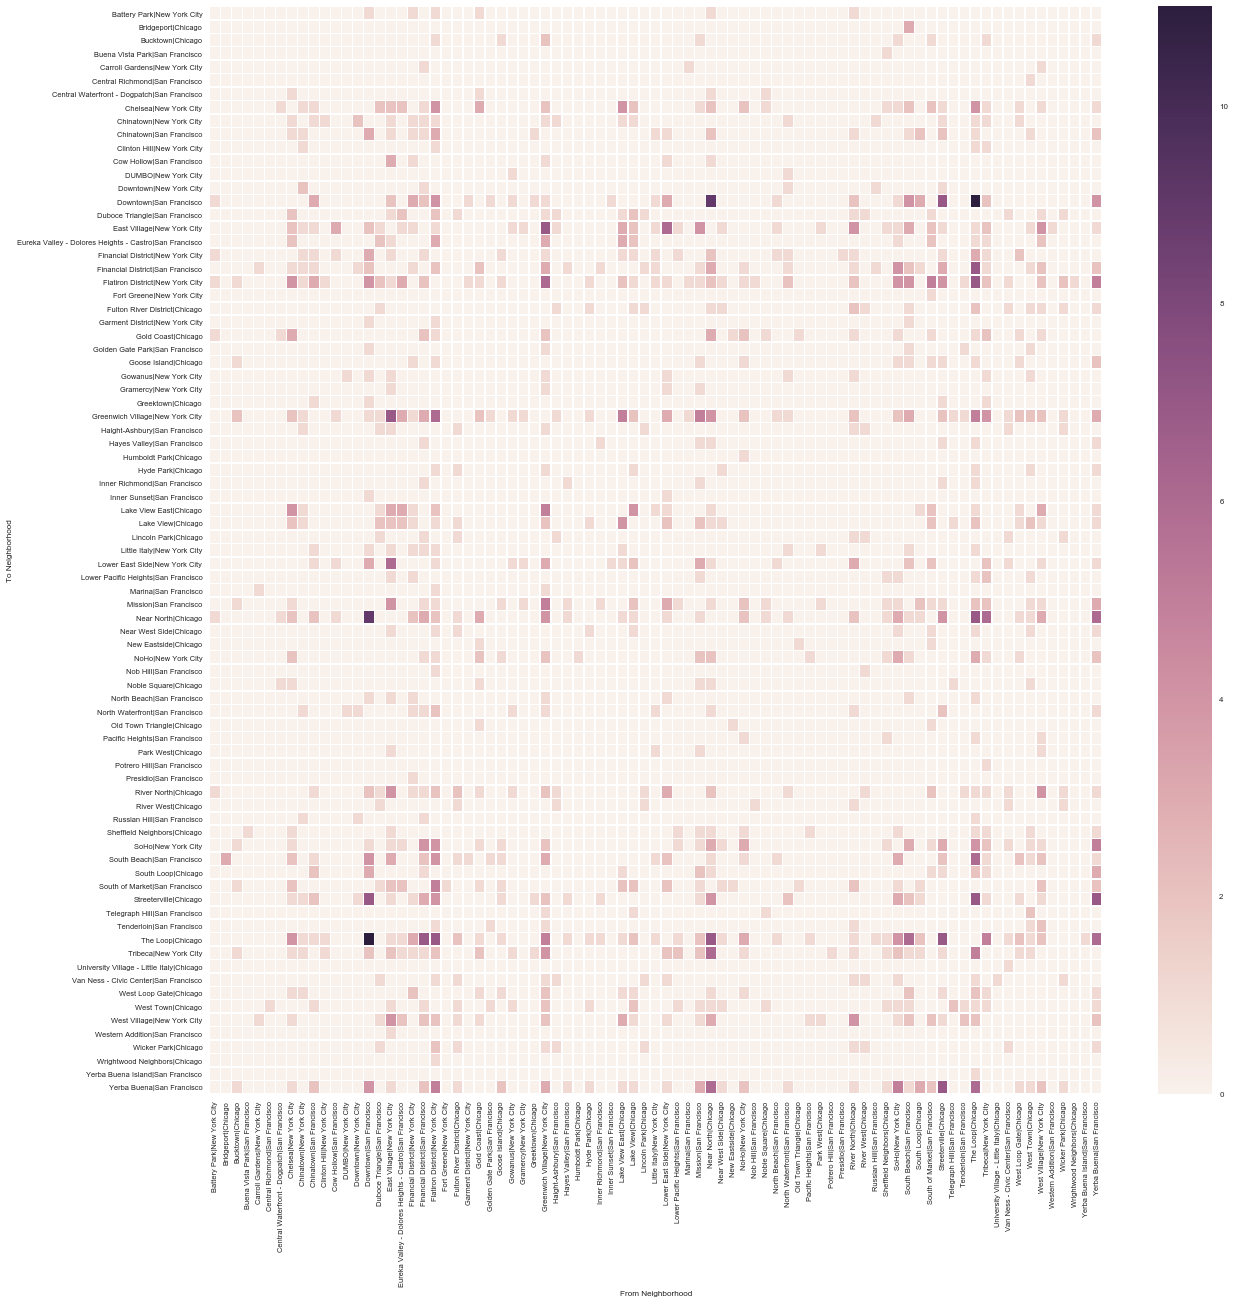

In [40]:
np_adj_matrix = np.matrix(adj_matrix)
tick_labels = unique_neighborhoods

fig, ax = plt.subplots(figsize=(20, 20));
sns.despine();
sns.set(font_scale=0.8)
state_graph_heatmap = sns.heatmap(np_adj_matrix, linewidths=.5, xticklabels=tick_labels, yticklabels=tick_labels)
state_graph_heatmap.set_xlabel('From Neighborhood')
state_graph_heatmap.set_ylabel('To Neighborhood')
state_graph_heatmap.set_title('')

In [63]:
# print out most common neighborhood pairs
city_pairing_dict = {}
matrix_size = len(adj_matrix)

for i in xrange(matrix_size):
    i_name = unique_neighborhoods[i]
    for j in xrange(matrix_size):
        j_name = unique_neighborhoods[j]

        pairing_key = i_name + ' to ' + j_name
        reverse_pairing_key = j_name + ' to ' + i_name
        
        if not(pairing_key in city_pairing_dict or reverse_pairing_key in city_pairing_dict):
            city_pairing_dict[pairing_key] = adj_matrix[i][j]

In [76]:
paring_list = city_pairing_dict.keys()
count_list = [city_pairing_dict[x] for x in paring_list]
pairing_df = pd.DataFrame.from_dict({'pairing': paring_list, 'count': count_list}).sort_values('count', ascending=False)

In [77]:
pairing_df

,count,pairing
234,11,Downtown|San Francisco to The Loop|Chicago
630,9,Downtown|San Francisco to Near North|Chicago
3273,7,East Village|New York City to Greenwich Villag...
1739,7,Streeterville|Chicago to Yerba Buena|San Franc...
1315,7,Financial District|San Francisco to The Loop|C...
1883,7,Near North|Chicago to The Loop|Chicago
2270,7,Flatiron District|New York City to The Loop|Ch...
1856,7,Downtown|San Francisco to Streeterville|Chicago
180,7,Streeterville|Chicago to The Loop|Chicago
1122,6,East Village|New York City to Lower East Side|...
